# Gaussian Processes

This notebook contains some exploratory examples of gaussian processes. The eventual goal (not for this notebook) is to build up to a bayesian functional optimization framework that can be used to find an optimum $\Delta x_e(z)$ which maximizes the likelihood for various values of $H_0$. 

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib as mpl 

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='large'
mpl.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams['text.usetex']=True
fsize=16

In [2]:
def rbf_kernel(var, length):
    def k(t1, t2):
        exponent = -scipy.spatial.distance.cdist(t1, t2, 'sqeuclidean')/(2*length**2)
        return var**2*np.exp(exponent)
    return k

def linear_kernel(sig, sig_b, c):
    def k(t1, t2):
        return sig_b**2 + sig**2*(t1-c)*(t2-c)
    return k

def mult_kernels(k1, k2):
    def k(t1, t2):
        return k1(t1, t2)*k2(t1, t2)
    return k

def create_cov(k, points):
    X = np.expand_dims(points, 1)
    return k(X, X)

# X are test points, Y are training points. Y would be your list of data points.
# This takes a covariance matrix and returns the contidioned covariance matrix

def condition(k, X, Y):
    print(len(X))
    xvalues = Y[:,0]
    yvalues = Y[:,1]
    mat = create_cov(k, np.hstack([X, xvalues]))
    sig_XX = mat[:len(X), :len(X)]
    sig_YY = mat[len(X):, len(X):]
    sig_XY = mat[:len(X), len(X):]
    sig_YX = sig_XY.T
    print(sig_XY.shape)
    mean = np.einsum("ij,jk,k->i", sig_XY, np.linalg.inv(sig_YY), yvalues)
    cov = sig_XX - np.einsum("ij,jk,kl->il", sig_XY, np.linalg.inv(sig_YY), sig_YX)

    return mean,cov


In [3]:
N=50
xlim = (-2, 2)
test_points = np.linspace(*xlim, N)
kernel = rbf_kernel(1, .7)
covmat = create_cov(k=kernel, points = test_points)
function_samples = []

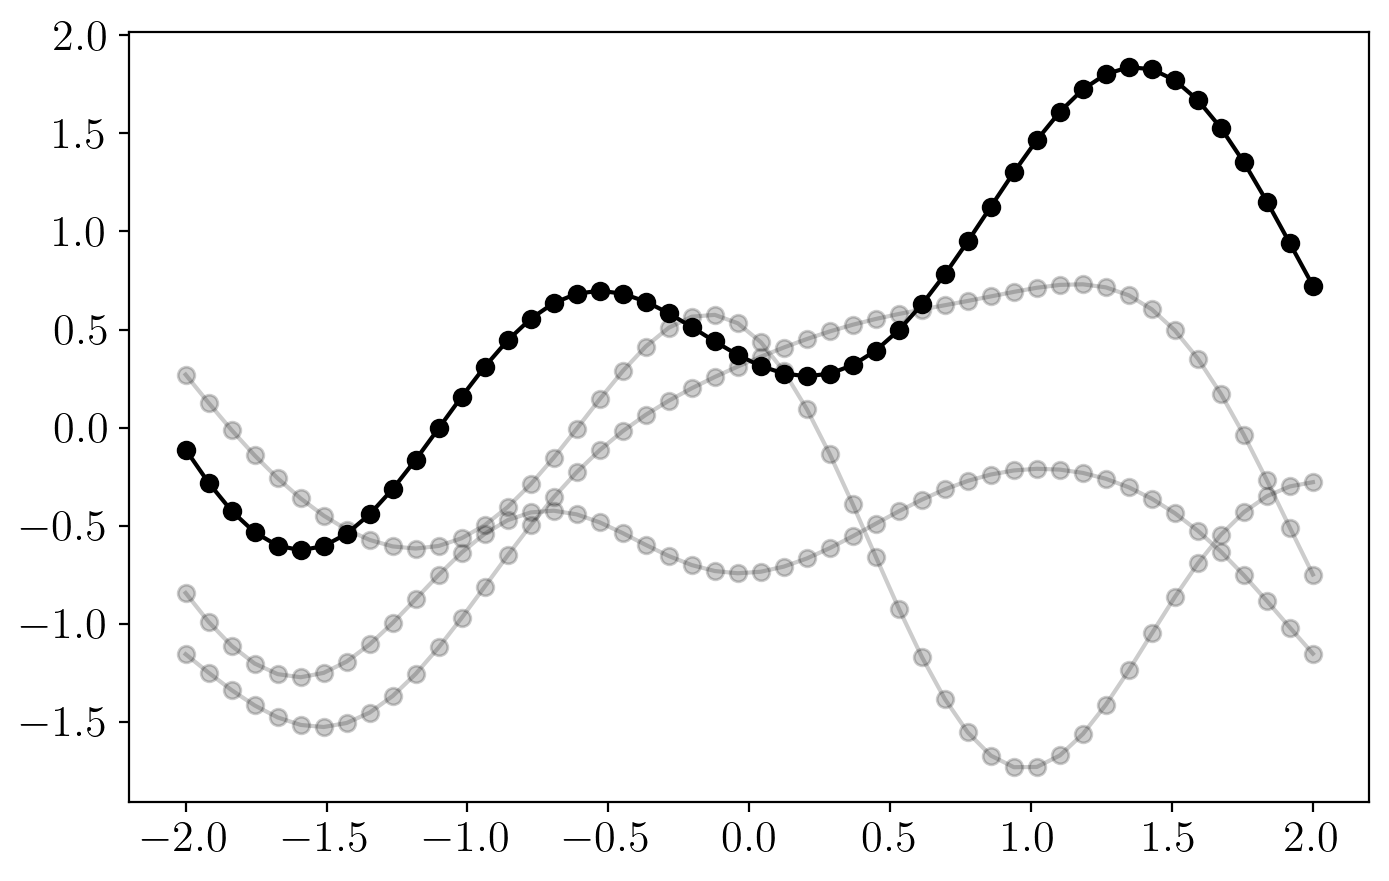

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
function_samples.append(np.random.multivariate_normal(mean=np.zeros(N), cov=covmat))

for i,sample in enumerate(function_samples):
    if i==len(function_samples)-1:
        a=1.0
    else:
        a=0.2
    ax.plot(test_points, sample, linestyle="-", marker="o", color="black", alpha=a)

plt.show()

Here we condition on the training points, i.e. we generate a new covariance matrix for the test points $X$ given the values at the points $Y$.

In [13]:
training_points = np.array([[-2, 0], [-.5, .5], [2, 0]])
mu, sig = condition(kernel, test_points, training_points)

function_samples = []
mu_reduced = mu
sig_reduced = sig

50
(50, 3)
[[ 3.33066907e-16  0.00000000e+00  2.22044605e-16 ...  1.73112359e-20
   5.24101636e-21  2.71050543e-20]
 [ 0.00000000e+00  1.26937345e-02  2.48296254e-02 ... -6.14633194e-05
  -2.49362943e-05  0.00000000e+00]
 [ 2.22044605e-16  2.48296254e-02  4.88698214e-02 ... -1.37429848e-04
  -5.57614373e-05  0.00000000e+00]
 ...
 [ 2.34522247e-20 -6.14633194e-05 -1.37429848e-04 ...  5.29412704e-02
   2.66492383e-02  0.00000000e+00]
 [-1.72053567e-21 -2.49362943e-05 -5.57614373e-05 ...  2.66492383e-02
   1.35069484e-02  0.00000000e+00]
 [-1.14746495e-20  1.28113733e-20  2.67344774e-20 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]


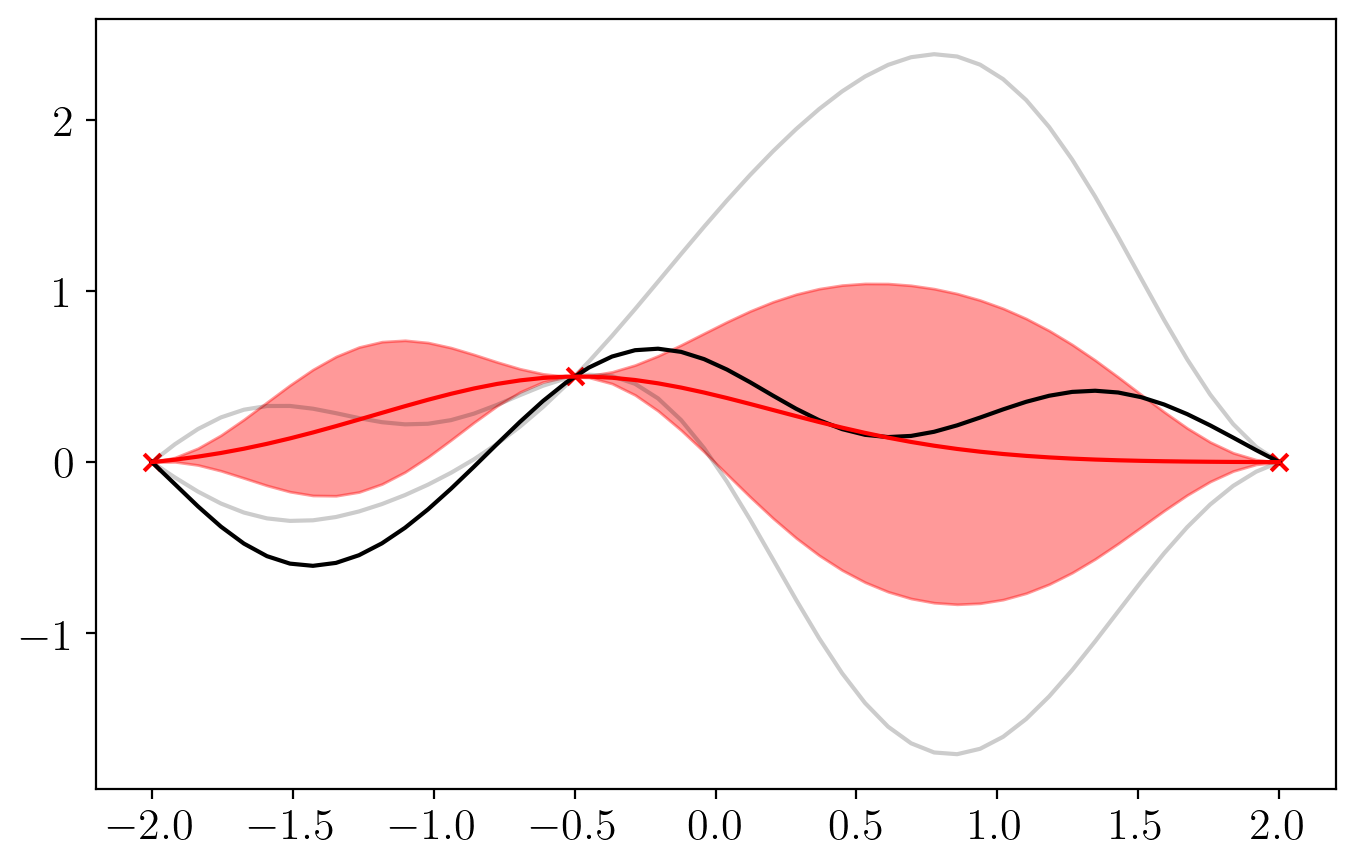

In [16]:
fig, ax = plt.subplots(figsize=(8,5))
function_samples.append(np.random.multivariate_normal(mean=mu_reduced, cov=sig_reduced))

upper_bound = mu_reduced+np.diag(sig_reduced)
lower_bound = mu_reduced-np.diag(sig_reduced)

for i,sample in enumerate(function_samples):
    if i==len(function_samples)-1:
        a=1.0
    else:
        a=0.2
    ax.plot(test_points, sample, linestyle="-", color="black", alpha=a)
ax.plot(test_points, mu, color="red")
ax.scatter(training_points[:,0], training_points[:,1], marker="x", color="red")
ax.fill_between(test_points, lower_bound, upper_bound, color="red", alpha=0.4)
plt.show()